<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/weaviate/HubermanWeaviate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://github.com/aigeek0x0/zephyr-7b-alpha-langchain-chatbot/tree/main

In [1]:
# install required packages
!pip install -q transformers peft accelerate bitsandbytes safetensors sentencepiece streamlit weaviate-client langchain sentence-transformers tiktoken youtube-transcript-api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.8/118.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.6 MB/s eta 0:

In [22]:
# fixing unicode error in google colab
import locale

locale.getpreferredencoding = lambda: "UTF-8"

# import dependencies
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from langchain.text_splitter import TokenTextSplitter
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceEmbeddings
from langchain import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain.vectorstores import Weaviate
import weaviate

# How to implement Weaviate RAG applications with Local LLMs and Embedding models
## Develop RAG applications and don’t share your private data with anyone!

In the spirit of Hacktoberfest, I decided to write a blog post using a vector database for change. The main reason for that is that in spirit of open source love, I have to give something back to Philip Vollet in exchange for all the significant exposure he provided me, starting from many years ago.

Philip works at Weaviate, which is a vector database, and vector similarity search is prevalent in retrieval-augmented applications nowadays. As you might imagine, we will be using Weaviate to power our RAG application. In addition, we’ll be using local LLM and embedding models, making it safe and convenient when dealing with private and confidential information that mustn’t leave your premises.

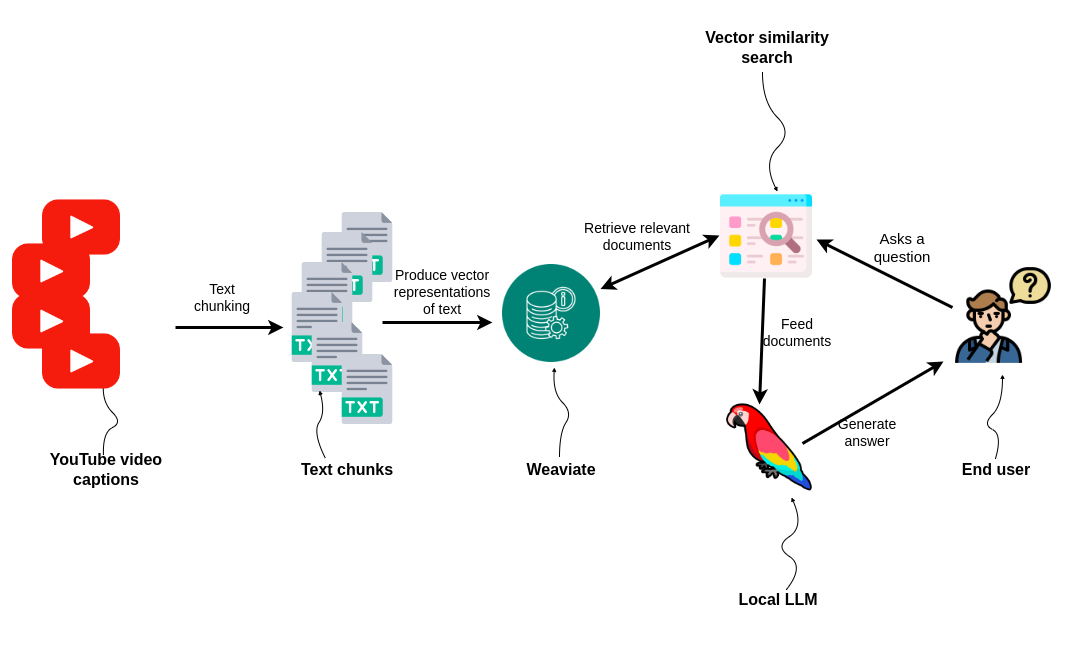

They say that knowledge is power, and Huberman Labs podcast is one of the finer source of information of scientific discussion and scientific-based tools to enhance your life. In this blog post, we will use LangChain to fetch podcast captions from YouTube, embed and store them in Weaviate, and then use a local LLM to build a RAG application.

## Weaviate cloud services
To follow the examples in this blog post, you first need to register with WCS. Once you are registered, you can create a new Weaviate Cluster by clicking the “Create cluster” button. For this tutorial, we will be using the free trial plan, which will provide you with a sandbox for 14 days.

For the next steps, you will need the following two pieces of information to access your cluster:

* The cluster URL
* Weaviate API key (under “Enabled — Authentication”)

In [2]:
WEAVIATE_URL = "https://weaviate.network"
WEAVIATE_API_KEY = "WEAVIATE_API_KEY"

client = weaviate.Client(
    url=WEAVIATE_URL, auth_client_secret=weaviate.AuthApiKey(WEAVIATE_API_KEY)
)

Local embedding and LLM models
I am most familiar with the LangChain LLM framework, so we will be using it to ingest documents as well as retrieve them. We will be using sentence_transformers/all-mpnet-base-v2 embedding model and zephyr-7b-alpha llm. Both of these models are open source and available on HuggingFace. The implementation code for these two models in LangChain was kindly borrowed from the following repository:

https://github.com/aigeek0x0/zephyr-7b-alpha-langchain-chatbot

We will begin by defining the embedding model, which can be easily retrieved from HuggingFace using the following code:

In [4]:
# specify embedding model (using huggingface sentence transformer)
embedding_model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda"}
embeddings = HuggingFaceEmbeddings(
    model_name=embedding_model_name, model_kwargs=model_kwargs
)

## Ingest HubermanLabs podcasts into Weaviate
I have learned that each channel on YouTube has an RSS feed, that can be used to fetch links to the latest 10 videos. As the RSS feed returns a XML, we need to employ a simple Python script to extract the links.

In [5]:
import requests
import xml.etree.ElementTree as ET

URL = "https://www.youtube.com/feeds/videos.xml?channel_id=UC2D2CMWXMOVWx7giW1n3LIg"

response = requests.get(URL)
xml_data = response.content

# Parse the XML data
root = ET.fromstring(xml_data)

# Define the namespace
namespaces = {
    "atom": "http://www.w3.org/2005/Atom",
    "media": "http://search.yahoo.com/mrss/",
}

# Extract YouTube links
youtube_links = [
    link.get("href")
    for link in root.findall(".//atom:link[@rel='alternate']", namespaces)
][1:]

Now that we have the links to the videos at hand, we can use the YoutubeLoader from LangChain to retrieve the captions. Next, as with most RAG ingestions pipelines, we have to chunk the text into smaller pieces before ingestion. We can use the text splitter functionality that is built into LangChain.

In [6]:
from langchain.document_loaders import YoutubeLoader

all_docs = []
for link in youtube_links:
    loader = YoutubeLoader.from_youtube_url(link)
    docs = loader.load()
    all_docs.extend(docs)
text_splitter = TokenTextSplitter(chunk_size=128, chunk_overlap=0)
split_docs = text_splitter.split_documents(all_docs)

vector_db = Weaviate.from_documents(
    split_docs, embeddings, client=client, by_text=False
)

You can test the vector retriever using the following code:



In [15]:
vector_db.similarity_search(
    "Which are tools to bolster your mental health?", k=3)


[Document(page_content=" your mental health in addition to that Dr Conte has generously provided a few PDFs which illustrate that framework for you and that are available completely zero cost by going to the links in the show note captions so you have the option to download those PDFs and to look them over either prior to or during or perhaps after you listen to these four podcast episodes as a final note before beginning today's discussion want to emphasize my sentiment which I'm confident will soon be your sentiment as well which is that Dr Paul Conti shares with us immensely powerful tools for enhancing mental health that at least to my knowledge have never been shared publicly before in fact as", metadata={'source': 'tLRCS48Ens4'}),
 Document(page_content=" of tools and protocols for improving mood and mental health some of which are grounded in that core six the you know first principles of self-care are always going to be getting your physiology right so that your psychology can 

## Setting up a local LLM
This part of the code was completely copied from the example provided by the AI Geek. It loads the `zephyr-7b-alpha-sharded` model and its tokenizer from HuggingFace and loads it as a LangChain LLM module.

In [10]:
# specify model huggingface mode name
model_name = "anakin87/zephyr-7b-alpha-sharded"

# function for loading 4-bit quantized model
def load_quantized_model(model_name: str):
    """
    :param model_name: Name or path of the model to be loaded.
    :return: Loaded quantized model.
    """
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        load_in_4bit=True,
        torch_dtype=torch.bfloat16,
        quantization_config=bnb_config,
    )
    return model

# function for initializing tokenizer
def initialize_tokenizer(model_name: str):
    """
    Initialize the tokenizer with the specified model_name.

    :param model_name: Name or path of the model for tokenizer initialization.
    :return: Initialized tokenizer.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name, return_token_type_ids=False)
    tokenizer.bos_token_id = 1  # Set beginning of sentence token id
    return tokenizer

# initialize tokenizer
tokenizer = initialize_tokenizer(model_name)
# load model
model = load_quantized_model(model_name)
# specify stop token ids
stop_token_ids = [0]

# build huggingface pipeline for using zephyr-7b-alpha
pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    use_cache=True,
    device_map="auto",
    max_length=2048,
    do_sample=True,
    top_k=5,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
)

# specify the llm
llm = HuggingFacePipeline(pipeline=pipeline)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

I haven’t played around yet, but you could probably reuse this code to load other LLMs from HuggingFace.

## Building a conversation chain
Now that we have our vector retrieval and th LLM ready, we can implement a retrieval-augmented chatbot in only a couple lines of code.

In [25]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm, chain_type="stuff", retriever=vector_db.as_retriever()
)

Let’s now test how well it works:



In [26]:
response = qa_chain.run(
    "How does one increase their mental health?")
print(response)

 In order to improve mental health, it is crucial to take care of one's biology. This can mean prioritizing sleep and sunlight, consuming necessary vitamins and minerals, and following specific protocols to gain agency over one's own mental health. By making a daily investment in the six core pillars and understanding the tools out there for improving mood, we can consistently enhance our mental health and build up our brain and body budget. This information is provided by Dr. Huberman, who aims to bring zero-cost consumer information about science and science-related tools to the general public.


Let’s try another one:



In [27]:
response = qa_chain.run("How to increase your willpower?")
print(response)

 According to the text, to increase your willpower, listen to episodes on dopamine motivation and drive or dopamine more generally. Additionally, the text suggests that rewarding oneself for engaging tenacity or willpower regularly is not recommended, and that rewarding actions in healthy and safe ways should be done sporadically for those who want to learn how to do so. However, this recommendation contradicts the Bal Meister theory of willpower as a limited resource, which has been contentious. To understand the psychology of willpower and tenacity, it's crucial to consider both the supporting and conflicting evidence.


## Summary
Only a couple of months ago, most of us didn’t realize that we will be able to run LLMs on our laptop or free-tier Google Collab so soon. Many RAG applications deal with private and confidential data, where it can’t be shared with third-party LLM providers. In those cases, using a local embedding and LLM models as described in this blog post is the ideal solution.